# Preparación del entorno

In [ ]:
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('./src/')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm
from algorithms.ucb1 import UCB1
from algorithms.ucb2 import UCB2
from arms.armbinomial import ArmBinomial
from arms import Bandit
from plotting import plot_average_rewards, plot_regret

['C:\\Users\\Musatom\\miniconda3\\python312.zip', 'C:\\Users\\Musatom\\miniconda3\\DLLs', 'C:\\Users\\Musatom\\miniconda3\\Lib', 'C:\\Users\\Musatom\\miniconda3', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml', '', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\Pythonwin', './src/', './src/']


# Experimento

In [12]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                # _, stats = arm_stats[idx]
                # # Registrar selecciones y recompensas en arm_stats
                # stats[chosen_arm][0] += 1  # Contador de selecciones
                # stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                # if chosen_arm == optimal_arm:
                #     optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    # optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    # for _, stats in arm_stats:
    #     for arm in stats:
    #         selections, total_reward = stats[arm]
    #         stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated

In [13]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos usando distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

Bandit with 10 arms: ArmBinomial(n=11, p=0.22479561626896213), ArmBinomial(n=8, p=0.14646688973455957), ArmBinomial(n=17, p=0.7929409166199481), ArmBinomial(n=19, p=0.5808920093945671), ArmBinomial(n=15, p=0.6664580622368363), ArmBinomial(n=12, p=0.11646759543664197), ArmBinomial(n=17, p=0.8759278817295955), ArmBinomial(n=9, p=0.7659541126403374), ArmBinomial(n=11, p=0.26987128854262094), ArmBinomial(n=14, p=0.24545997376568052)
Optimal arm: 7 with expected reward=14.890773989403122


# UCB1

In [14]:
# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
ucb1_algorithms = [UCB1(k, c=0.5), UCB1(k, c=1.0), UCB1(k, c=2.0)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_UCB1, optimal_selections_UCB1, arm_stats_UCB1, regret_accumulated_UCB1 = run_experiment(bandit, ucb1_algorithms, steps, runs)

## Recompensa promedio

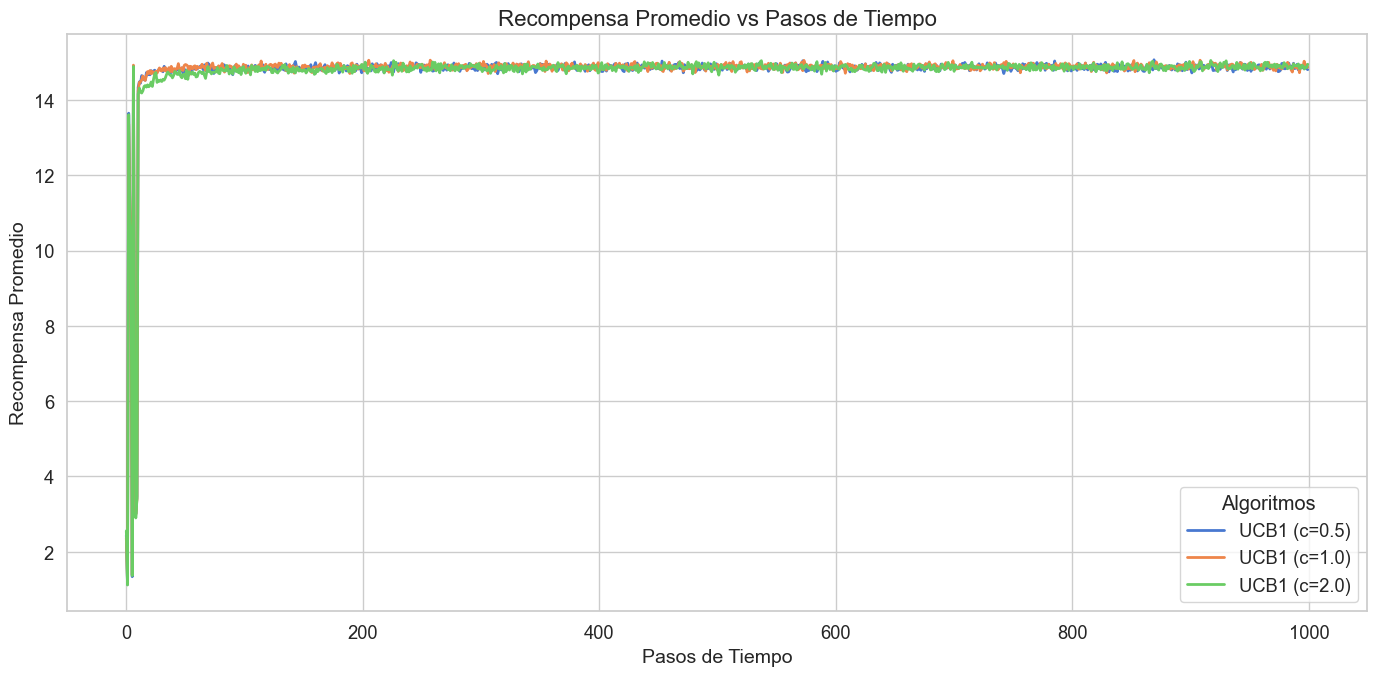

In [15]:
plot_average_rewards(steps, rewards_UCB1, ucb1_algorithms)

## Regret acumulado

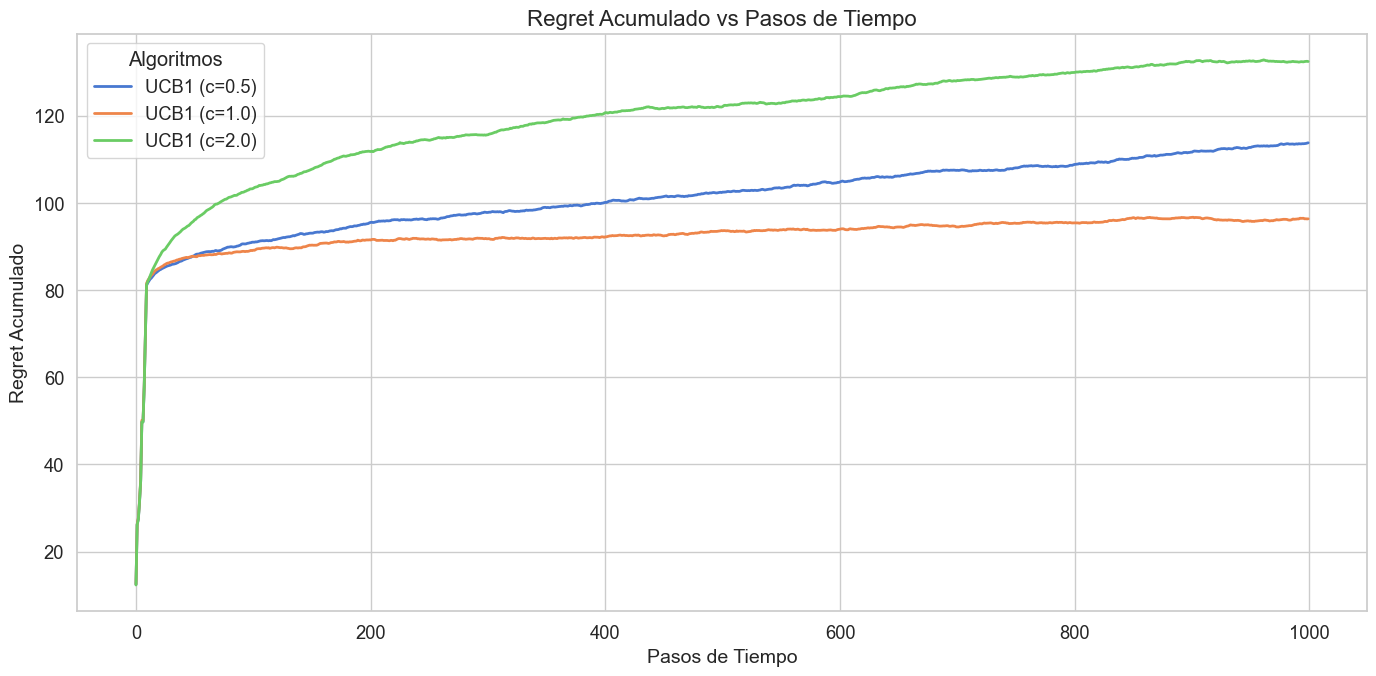

In [ ]:
plot_regret(steps, regret_accumulated_UCB1, ucb1_algorithms)

# UCB2

In [17]:
# Definir los algoritmos a comparar. Ahora usamos el otro algoritmo pedido de la familia UCB: UCB2, con diferentes valores del parámetro de ajuste de exploración alpha.
ucb2_algorithms = [UCB2(k, alpha=0.01), UCB2(k, alpha=0.1), UCB2(k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_UCB2, _, _, regret_accumulated_UCB2 = run_experiment(bandit, ucb2_algorithms, steps, runs)

## Recompensa promedio

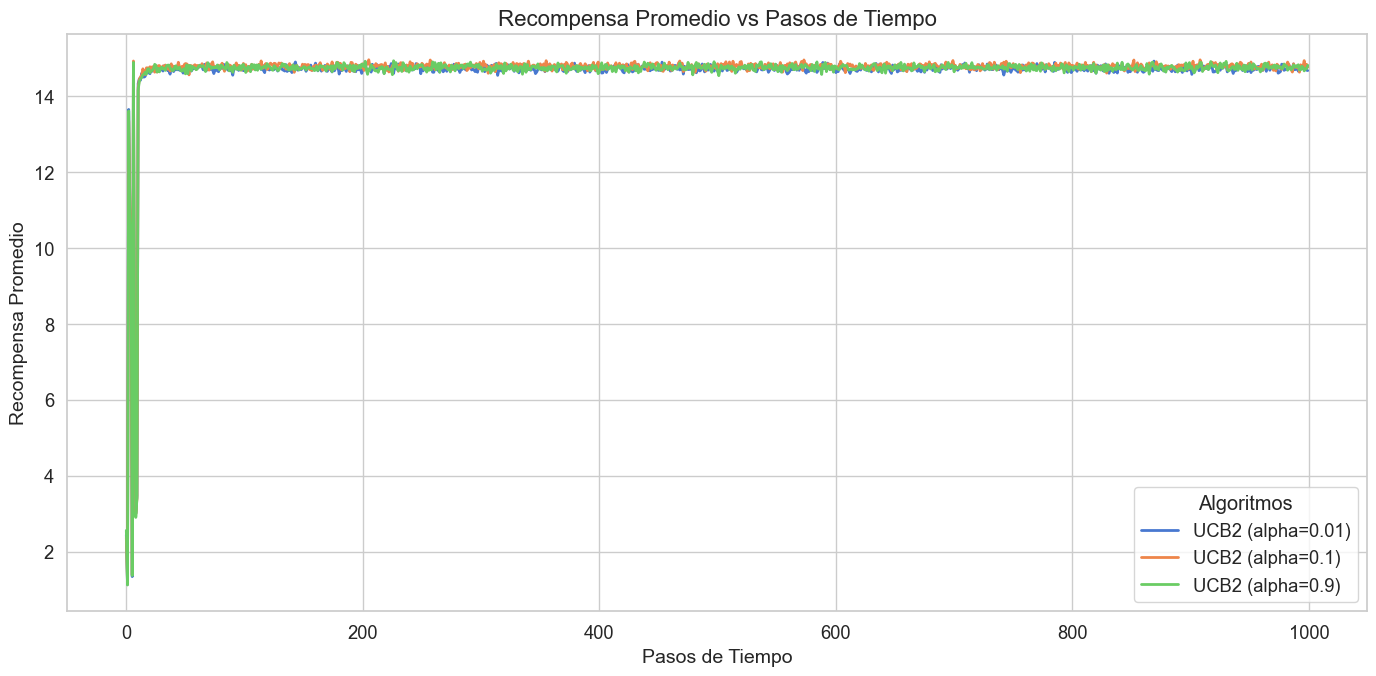

In [18]:
plot_average_rewards(steps, rewards_UCB2, ucb2_algorithms)

## Regret acumulado

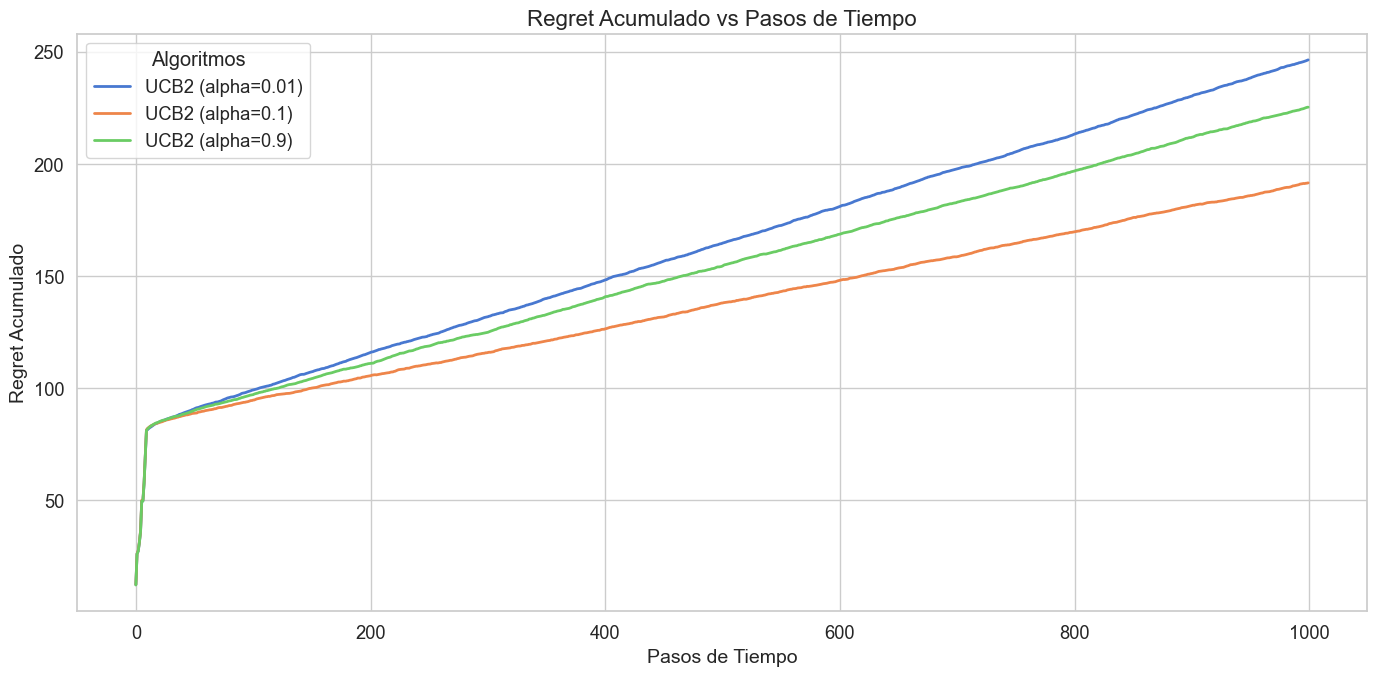

In [19]:
plot_regret(steps, regret_accumulated_UCB2, ucb2_algorithms)

# UCB1 vs UCB2

## Recompensa promedio

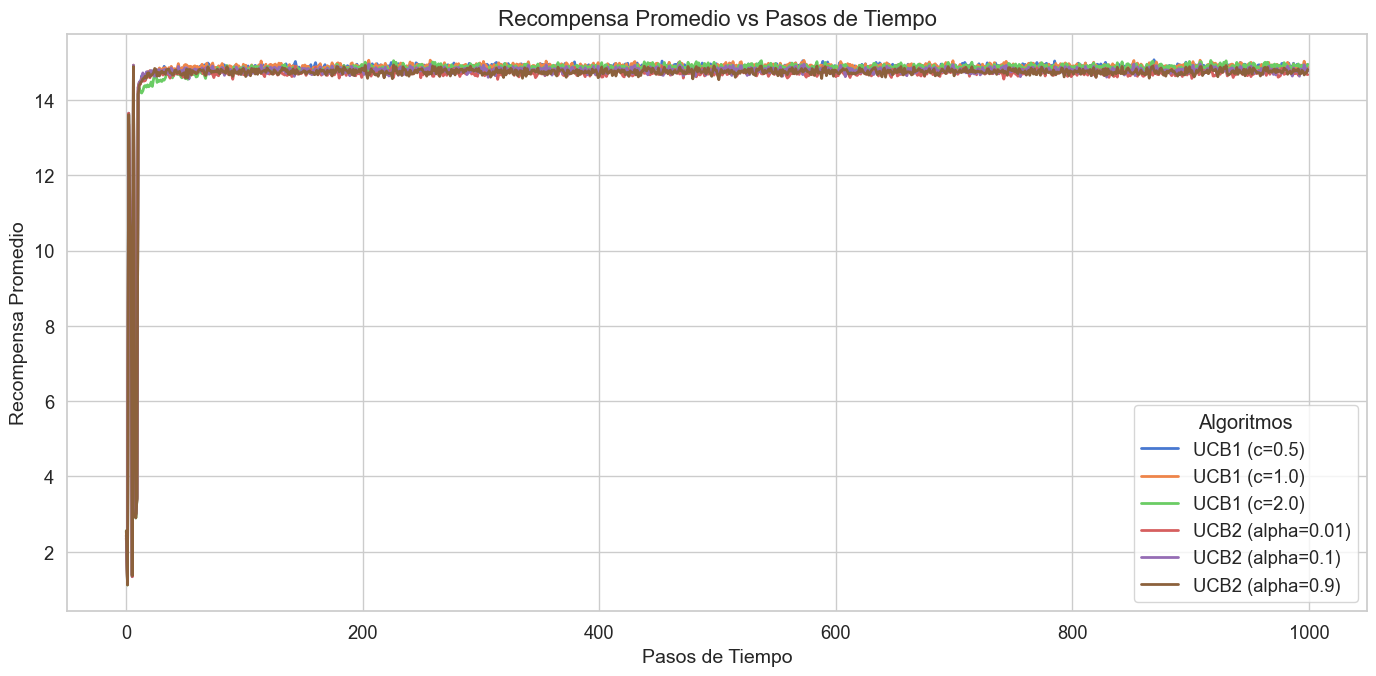

In [20]:
plot_average_rewards(steps, np.vstack((rewards_UCB1, rewards_UCB2)), ucb1_algorithms+ucb2_algorithms)

## Regret acumulado

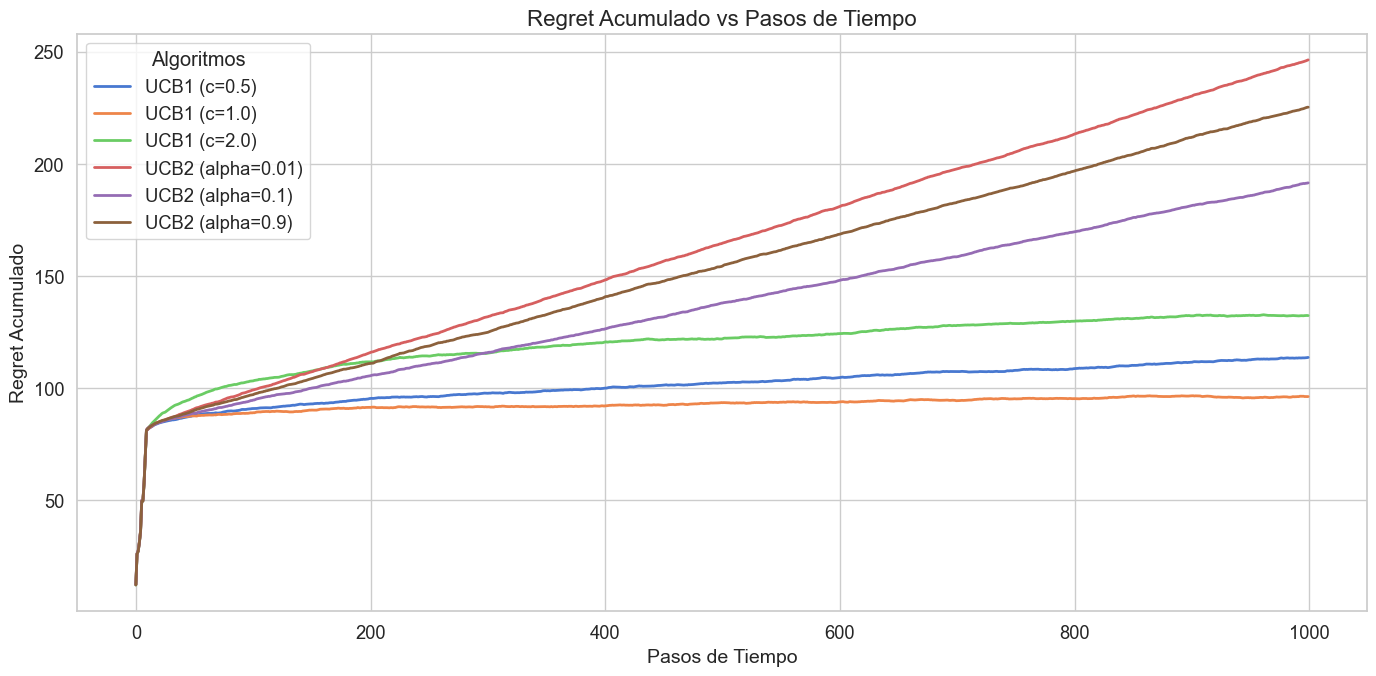

In [21]:
plot_regret(steps, np.vstack((regret_accumulated_UCB1, regret_accumulated_UCB2)), ucb1_algorithms+ucb2_algorithms)